In [85]:
import pm4py, pandas as pd, numpy as np
from pm4py.visualization.petri_net import visualizer as pn_viz

from pm4py.algo.discovery.inductive import algorithm as im
from pm4py.algo.discovery.heuristics import algorithm as hm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.evaluation.replay_fitness.variants import token_replay as rf_token
from pm4py.algo.evaluation.precision import algorithm as prec_alg 
from pm4py.algo.evaluation.generalization import algorithm as gen_eval
from pm4py.algo.evaluation.simplicity import algorithm as simp_eval
from pm4py.statistics.variants.log import get as variants_get


log = pm4py.read_xes('/Users/simonimmler/PycharmProjects/Praktikum/data/BPI Challenge 2017.xes') # Todo: Change
df  = pm4py.convert_to_dataframe(log)

# clean the event log by removing events without case identifiers or timestamps, converting timestamps into a unified datetime format, dropping invalid dates, sorting all events chronologically within each case. This ensures a consistent and well-ordered event sequence for all subsequent discovery, conformance, and prediction steps. Does not feature different quality metrics but is included for consistency 
df = (df.dropna(subset=["case:concept:name","time:timestamp"])
        .assign(ts=pd.to_datetime(df["time:timestamp"], utc=True, errors="coerce"))
        .dropna(subset=["ts"])
        .sort_values(["case:concept:name","ts"]))

# only complete Todo: To reproduce Figure 1 comment out this code
if "lifecycle:transition" in df.columns:
    df = df[df["lifecycle:transition"].eq("complete")]
  
elog = pm4py.convert_to_event_log(df)


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

Top 10 most frequent variants:

In [86]:
variants = variants_get.get_variants(elog)
sorted_variants = sorted(variants.items(),key=lambda item: len(item[1]),reverse=True)
print("Top 10 variants:")
for variant, trace_list in sorted_variants[:10]:
    print(f"{variant} {len(trace_list)}")

Top 10 variants:
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Cancelled', 'O_Cancelled') 2209
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Cancelled', 'O_Cancelled') 1917
('A_Create Application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Cancelled', 'O_Cancelled') 1578
('A_Create Application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Validating', 'O_Returned', 'O_Accepted', 'A_Pending') 969
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Validating', 'O_Returned', 'O_Accepted', 'A_Pending') 676
('A_Crea

Variant Coverage 90% , 95%

In [87]:
elog_full = pm4py.convert_to_event_log(df)
vdict = variants_get.get_variants(elog_full)
print(len(vdict))

counts = sorted([len(trs) for trs in vdict.values()], reverse=True)

cum = np.cumsum(counts) / np.sum(counts)
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)

print("Variant Coverage:")
print({"variants 90%": k90, "variants 95%": k95})

5623
Variant Coverage:
{'variants 90%': 2473, 'variants 95%': 4048}


In [88]:
num_events = sum(len(trace) for trace in elog)
print(f"Events: {num_events}")

Events: 475306


# 1 Inductive Miner

In [112]:
params = {"noise_threshold": 0.45}
pt = im.apply(elog, variant=im.Variants.IMf, parameters = params)
net, imap, fmap = pt_converter.apply(pt, variant=pt_converter.Variants.TO_PETRI_NET)

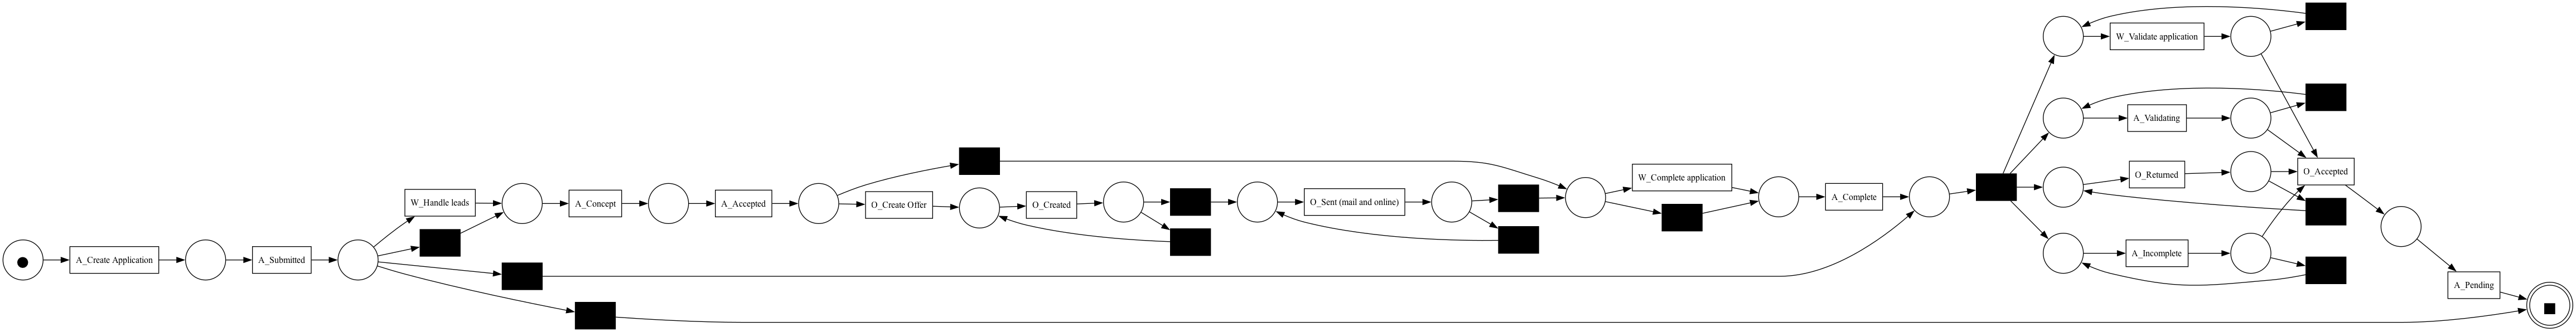

In [113]:
gviz = pn_viz.apply(net, imap, fmap)   
pn_viz.view(gviz)                      
#pn_viz.save(gviz, "../figures/model_imf1.png")  

Quality Metrics of Inductive Miner

a) alignment based fitness

In [91]:
# INFO: Remove comments to run this code, might take a while

from pm4py.algo.evaluation.replay_fitness.variants import alignment_based as rf_align
res_align = rf_align.apply(elog, net, imap, fmap)  
print(res_align)

aligning log, completed variants ::   0%|          | 0/5623 [00:00<?, ?it/s]

{'percFitTraces': 4.290837538481069, 'averageFitness': 0.6562922711977579, 'percentage_of_fitting_traces': 4.290837538481069, 'average_trace_fitness': 0.6562922711977579, 'log_fitness': 0.6819738836992032}


b) token replay based fitness

In [92]:
res_replay = rf_token.apply(elog, net, imap, fmap)
print(res_replay)

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

{'perc_fit_traces': 5.277857120187883, 'average_trace_fitness': 0.9004426235384455, 'log_fitness': 0.9085215066052112, 'percentage_of_fitting_traces': 5.277857120187883}


Precision

In [93]:
precision = prec_alg.apply(elog, net, imap, fmap,variant=prec_alg.Variants.ETCONFORMANCE_TOKEN)
print(precision)

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

0.5325507875533304


Generalization

In [94]:
generalization = gen_eval.apply(elog, net, imap, fmap)
print(generalization)

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

0.840556195817554


Simplicity

In [95]:
results = {
    "arc_degree":       simp_eval.apply(net, variant=simp_eval.Variants.SIMPLICITY_ARC_DEGREE),
    "extended_cardoso": simp_eval.apply(net, variant=simp_eval.Variants.EXTENDED_CARDOSO),
    "extended_cyclo":   simp_eval.apply(net, variant=simp_eval.Variants.EXTENDED_CYCLOMATIC),
}

print("Simplicity (Arc Degree):      ", results["arc_degree"])
print("Simplicity (Extended Cardoso):", results["extended_cardoso"])
print("Simplicity (Extended Cyclo.): ", results["extended_cyclo"])


Simplicity (Arc Degree):       0.6708860759493671
Simplicity (Extended Cardoso): 31
Simplicity (Extended Cyclo.):  86


Own Simplicity Metrics

In [96]:
def compute_simplicity(net):
    return {
        "size": simplicity_size(net),
        "edge_density": simplicity_edge_density(net),
        "invisible_share": simplicity_invisible_share(net)
    }


def simplicity_size(net):
    return len(net.places) + len(net.transitions)


def simplicity_edge_density(net):
    P = len(net.places)
    T = len(net.transitions)
    A = len(net.arcs)
    if (P + T) == 0:
        return 0
    return A / (P + T)


def simplicity_invisible_share(net):
    invisible = sum(1 for t in net.transitions if not t.label)
    return invisible / max(len(net.transitions), 1)


simp_im = compute_simplicity(net)
print(simp_im)

{'size': 53, 'edge_density': 1.2452830188679245, 'invisible_share': 0.4666666666666667}


Earth Mover Distance

In [97]:
#from pm4py.algo.evaluation.earth_mover_distance import algorithm as emd_ev
#emd = emd_ev.apply(elog, net, imap, fmap)

#print(emd)

# 2 Heuristics Miner

In [98]:
elog = pm4py.convert_to_event_log(df)
params = {
    "dependency_thresh": 0.1,        
    "and_measure_thresh": 0.85,       
    "min_act_count": 30000,           #good threshhold for a total of around 31 thousand cases
}
net, imap, fmap = hm.apply(elog, parameters=params)

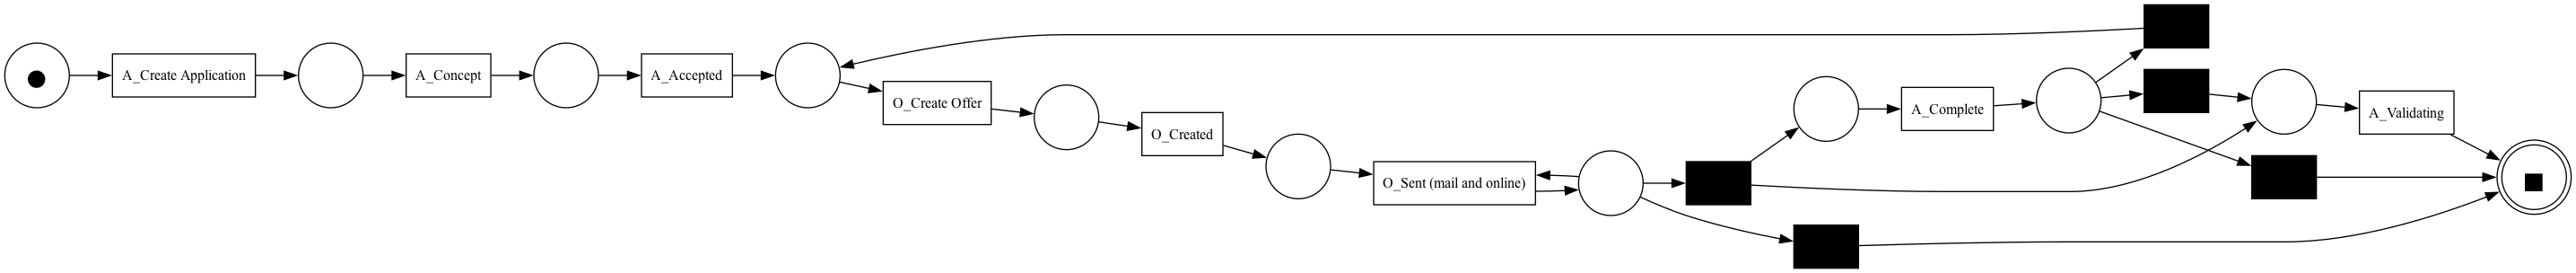

Places: 11 Transitions: 13 Arcs: 28
expls: ['A_Accepted', 'A_Complete', 'A_Concept', 'A_Create Application', 'A_Validating', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)']


In [99]:
gviz = pn_viz.apply(net, imap, fmap)
pn_viz.view(gviz)
#pn_viz.save(gviz, "../figures/heuristics_miner_petri.png")

print("Places:", len(net.places), "Transitions:", len(net.transitions), "Arcs:", len(net.arcs))
print("expls:", sorted([t.label for t in net.transitions if t.label])[:12])

Quality Metrics of Heuristic  Miner

a) Alignment-based Fitness (does not work on petri nets that are unsound)

In [100]:
#res_align = rf_align.apply(elog, net, imap, fmap)
#print(res_align)

b) Token-Replay Fitness 

In [101]:
res_replay = rf_token.apply(elog, net, imap, fmap)
print("Token-Replay Fitness:")
print(res_replay)

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

Token-Replay Fitness:
{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8957138338768358, 'log_fitness': 0.891291964492911, 'percentage_of_fitting_traces': 0.0}


Precision

In [102]:
precision = prec_alg.apply(elog, net, imap, fmap,variant=prec_alg.Variants.ETCONFORMANCE_TOKEN)
print("Precision:", precision)

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

Precision: 0.9999834709833112


Generalization

In [103]:
generalization = gen_eval.apply(elog, net, imap, fmap)
print("Generalization:", generalization)

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

Generalization: 0.9912743113801554


PM4PY Simplicity Metrics

In [104]:
results = {
    "arc_degree": simp_eval.apply(net, variant=simp_eval.Variants.SIMPLICITY_ARC_DEGREE),
    "extended_cardoso": simp_eval.apply(net, variant=simp_eval.Variants.EXTENDED_CARDOSO),
    #"extended_cyclomatic": simp_eval.apply(net, variant=simp_eval.Variants.EXTENDED_CYCLOMATIC),
}

print("Simplicity (Arc Degree):      ", results["arc_degree"])
print("Simplicity (Extended Cardoso):", results["extended_cardoso"])
#print("Simplicity (Extended Cyclo.): ", results["extended_cyclo"])

Simplicity (Arc Degree):       0.7499999999999999
Simplicity (Extended Cardoso): 14


Own Simplicity Metrics 

In [105]:
simp_im = compute_simplicity(net)
print("Own Simplicity Metrics:", simp_im)

Own Simplicity Metrics: {'size': 24, 'edge_density': 1.1666666666666667, 'invisible_share': 0.38461538461538464}


Earth Mover Distance (optional)

In [106]:
# from pm4py.algo.evaluation.earth_mover_distance import algorithm as emd_ev
# emd = emd_ev.apply(lang1, lang2, variant=emd_ev.Variants.PYEMD)
# print("EMD:", emd)

# 3 Alpha Miner

In [107]:
parameters = {
    "activity_key": "concept:name",
    "case_id_key": "concept:case:name",
    "timestamp_key": "time:timestamp",
    "variant": alpha_miner.Variants.ALPHA_VERSION_PLUS  
}

net_alpha, im_alpha, fm_alpha = alpha_miner.apply(df, parameters= parameters)

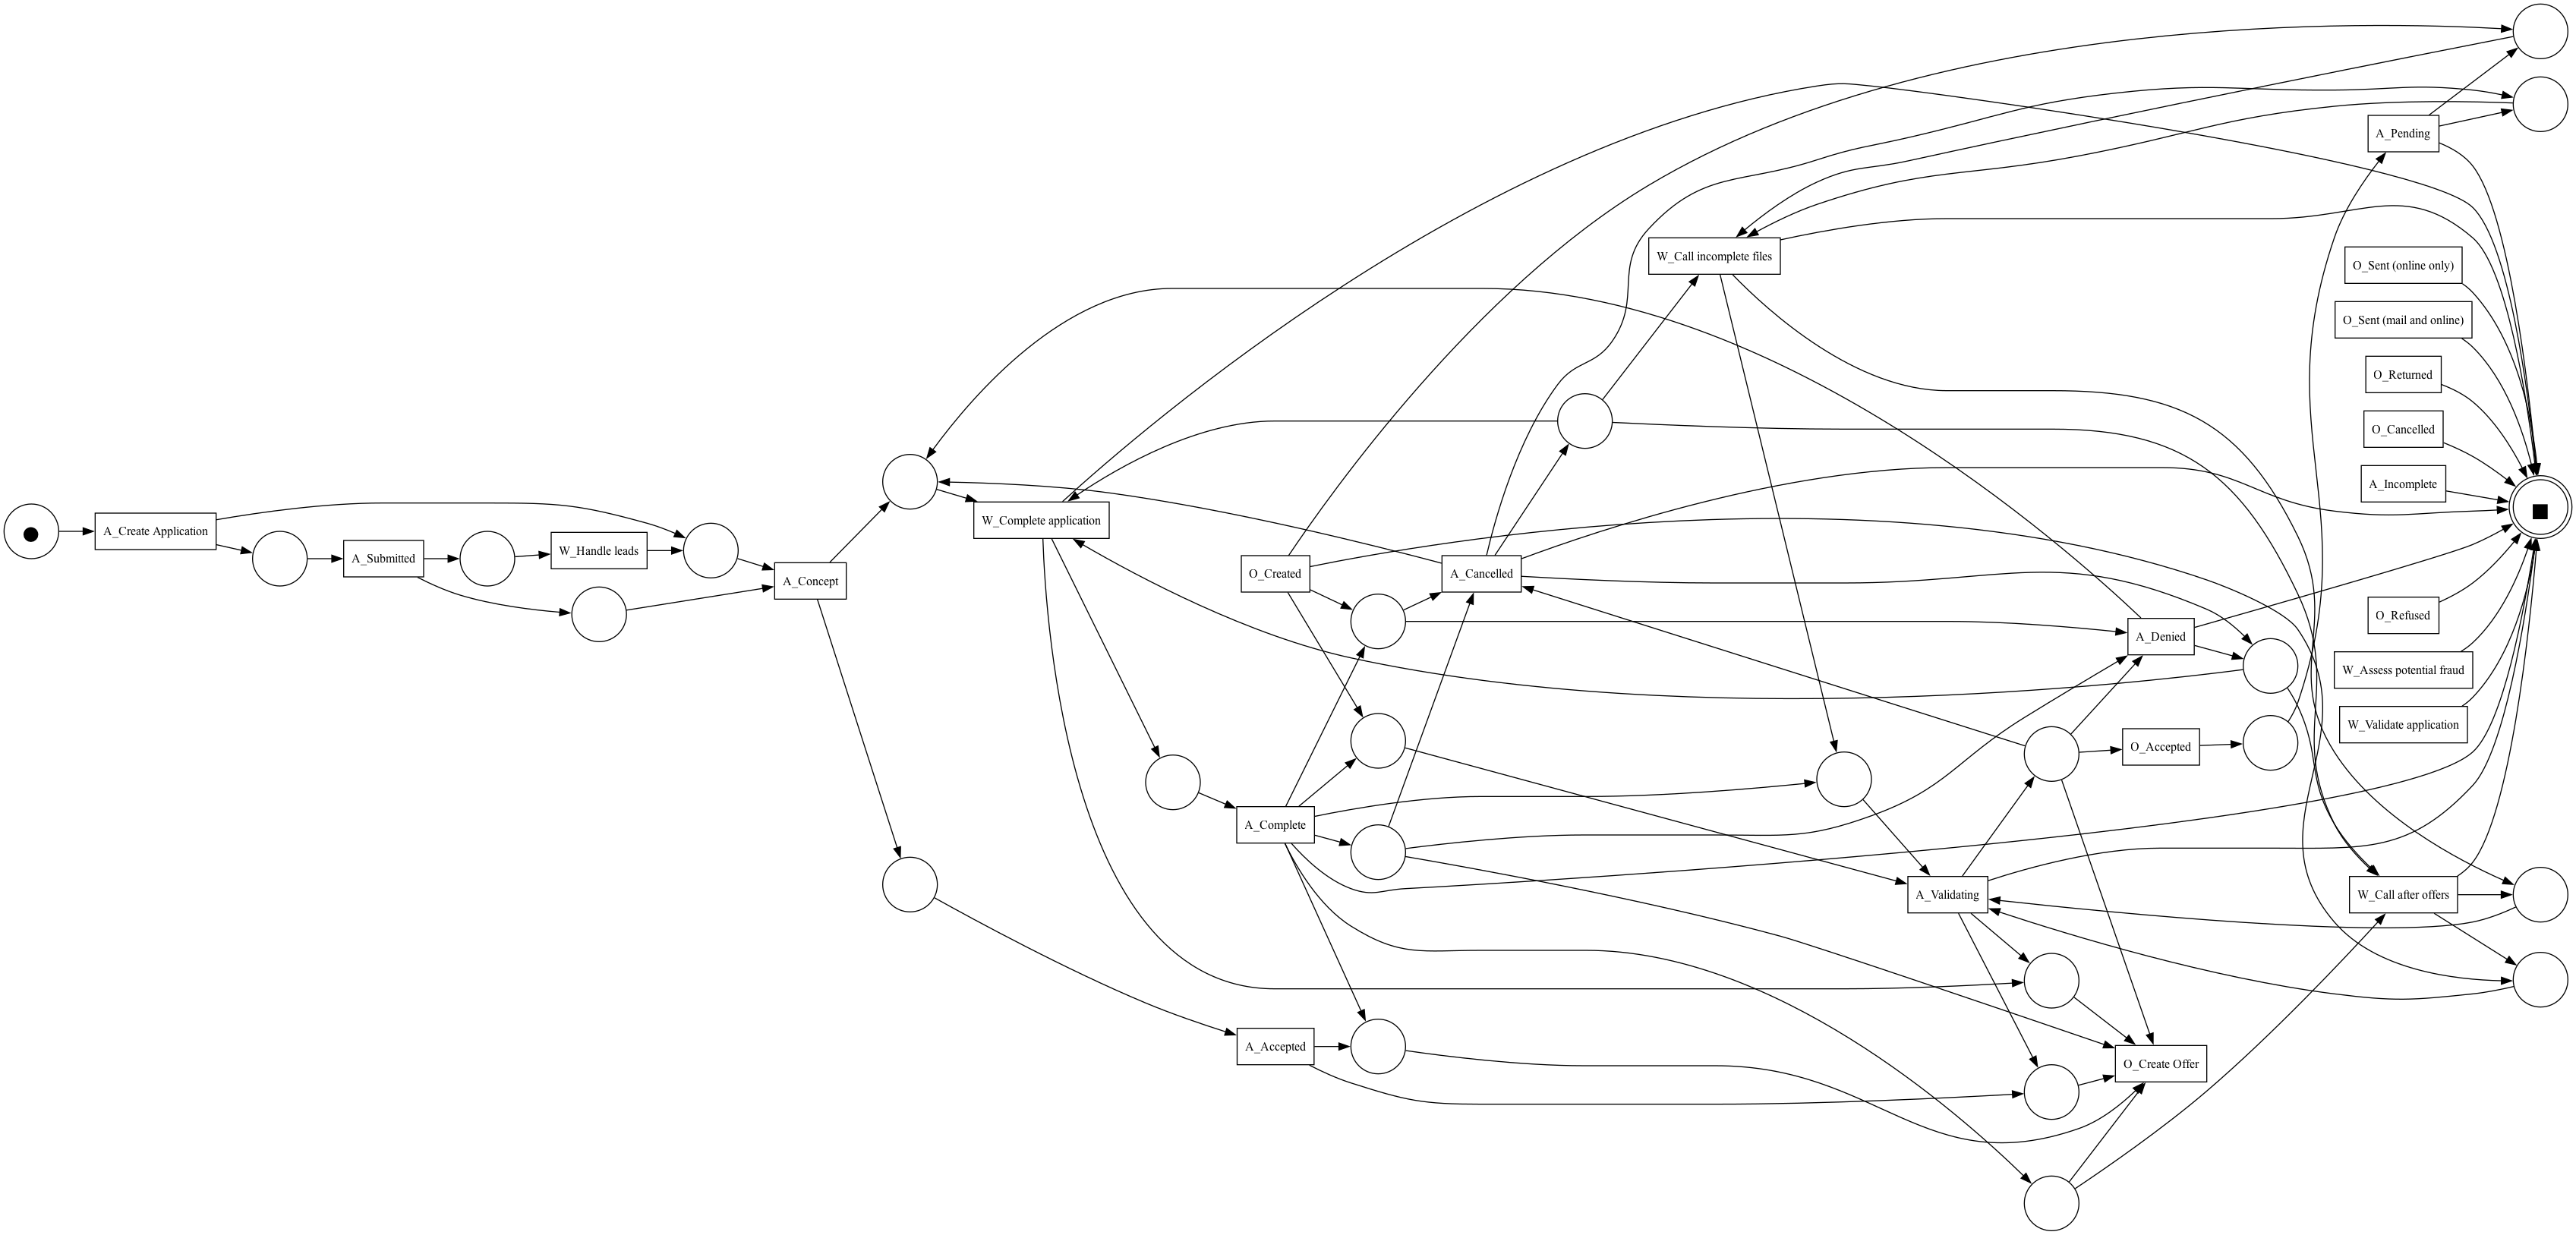

Places: 11 Transitions: 13 Arcs: 28
expls: ['A_Accepted', 'A_Complete', 'A_Concept', 'A_Create Application', 'A_Validating', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)']


In [108]:
gviz = pn_viz.apply(net_alpha, im_alpha, fm_alpha)
pn_viz.view(gviz)
#pn_viz.save(gviz, "../figures/alpha_miner_petri.png")

print("Places:", len(net.places), "Transitions:", len(net.transitions), "Arcs:", len(net.arcs))
print("expls:", sorted([t.label for t in net.transitions if t.label])[:12])

Quality Metrics

In [109]:
elog = pm4py.convert_to_event_log(df)

# Fitness (Token-based)
fitness_alpha = rf_token.apply(elog, net_alpha, im_alpha, fm_alpha,)

# Precision
precision_alpha = prec_alg.apply(elog, net_alpha, im_alpha, fm_alpha)

# Generalization
generalization_alpha = gen_eval.apply(elog, net_alpha, im_alpha, fm_alpha)

# Simplicity
simplicity_alpha = simp_eval.apply(net_alpha)

print("Alpha Miner quality:")
print("  Fitness:", fitness_alpha)
print("  Precision:", precision_alpha)
print("  Simplicity:", simplicity_alpha)
print("  Generalization:", generalization_alpha)

simp_al = compute_simplicity(net_alpha)
print("Own Simplicity Metrics:", simp_al)


replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

Alpha Miner quality:
  Fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.50011172988835, 'log_fitness': 0.495774473479623, 'percentage_of_fitting_traces': 0.0}
  Precision: 0.12590195124851544
  Simplicity: 0.392
  Generalization: 0.9869939686795314
Own Simplicity Metrics: {'size': 49, 'edge_density': 1.7755102040816326, 'invisible_share': 0.0}


In [110]:
#res_align = rf_align.apply(elog, net_alpha, im_alpha, fm_alpha)
#print(res_align)